## dunno, testing dataloaders

In [215]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class AffectNetDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 1]
        img_path = img_path = os.path.join(self.root_dir, f"class00{self.data.iloc[idx, 0]}", img_name)
        image = Image.open(img_path).convert("RGB")
        
        label = self.data.iloc[idx, 0] - 1
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [216]:
train_csv = "affectnet_train_direction.csv"
val_csv = "affectnet_val_direction.csv"
train_dir = "data/affectnet/train/"
val_dir = "data/affectnet/val_class/"

In [217]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [218]:
train_dataset = AffectNetDataset(train_csv, train_dir, transform=transform)
val_dataset = AffectNetDataset(val_csv, val_dir, transform=transform)

In [219]:
batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

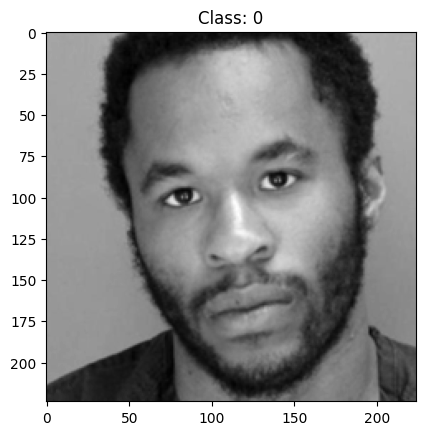

In [220]:
example_image, example_label = train_dataset[0]

image_np = example_image.numpy()
image_np = np.transpose(image_np, (1, 2, 0)) 

plt.imshow(image_np, cmap="gray")
plt.title(f'Class: {example_label}')
plt.show()

In [228]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 56 * 56, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.relu(x)
        return x
        

In [229]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device

device(type='cuda')

In [231]:
num_classes = 8
model = EmotionCNN(num_classes).to(device)
model

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [232]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [233]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, preds = predictions.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
        
    train_loss /= len(train_dataloader)
    train_accuract = correct / total
    
    # Val
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            predictions = model(images)
            loss = criterion(predictions, labels)
            
            val_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
            
    val_loss /= len(val_dataloader)
    val_accuracy = correct / toal
    
    print(f"Epoch [{epoch+1}/{num_epochs}]\t"
          f"Train Loss: {train_loss:.4f}\t"
          f"Train Accuracy: {train_accuracy*100:.2f}%\t"
          f"Val Loss: {val_loss:.4f}\t"
          f"Val Accuracy: {val_accuracy*100:.2f}%")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
